# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

# Step 1: Install

Install Pytorch

In [ ]:
!python --version # Python 3.7.14
!pip install torch torchvision

Python 3.7.14
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading the Dataset

In [ ]:
!wget https://raw.githubusercontent.com/nirajpandkar/flowers-classification-pytorch/master/cat_to_name.json
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!mkdir data && tar -xvf flower_data.tar.gz -C data

Streaming output truncated to the last 5000 lines.
train/75/image_02161.jpg
train/75/image_02096.jpg
train/75/image_02181.jpg
train/75/image_02079.jpg
train/75/image_02129.jpg
train/75/image_02073.jpg
train/75/image_02162.jpg
train/75/image_02082.jpg
train/75/image_02098.jpg
train/75/image_02080.jpg
train/75/image_02150.jpg
train/75/image_02159.jpg
train/75/image_02158.jpg
train/75/image_02163.jpg
train/75/image_02160.jpg
train/75/image_02134.jpg
train/75/image_02101.jpg
train/75/image_02171.jpg
train/75/image_02117.jpg
train/75/image_02137.jpg
train/75/image_02136.jpg
train/75/image_02102.jpg
train/75/image_02146.jpg
train/75/image_02177.jpg
train/75/image_02110.jpg
train/75/image_02123.jpg
train/75/image_02105.jpg
train/75/image_02076.jpg
train/75/image_02116.jpg
train/75/image_02170.jpg
train/75/image_02132.jpg
train/75/image_02122.jpg
train/75/image_02090.jpg
train/75/image_02138.jpg
train/75/image_02097.jpg
train/75/image_02106.jpg
train/75/image_02084.jpg
train/75/image_02087.jpg

Import Library

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.autograd import Variable
from PIL import Image
%matplotlib inline

Test

In [ ]:
# Create tensor of ones (FloatTensor by default)
ones = torch.ones(3, 2)
print(ones)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


# Step 2: Load data

In [ ]:
import torchvision.transforms as T

data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
batch_size = 64
num_workers = 2

Creating a Custom PyTorch Dataset

In [ ]:
import os,json

class FlowersDataset(ImageFolder):
    def __init__(self, root, transform):
        self.root = root
        super().__init__(self.root)
        self.files = [folder+"/"+fname for folder in os.listdir(root) for fname in os.listdir(root+"/"+folder) if fname.endswith('.jpg')]
        self.transform = transform
        with open('cat_to_name.json', 'r') as f:
          self.classes_idx = json.load(f)
        category_map = sorted(self.classes_idx.items(), key=lambda x: int(x[0]))
        self.classes = [cat[1] for cat in category_map]
    
    def __len__(self):
        return len(self.files)

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['102'])

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

Creating Training, Validation and Test Sets

In [ ]:
tranforms = T.Compose([T.Resize(img_size), 
                        T.Pad(8, padding_mode='reflect'),
                        T.RandomCrop(img_size), 
                        T.ToTensor(), 
                        T.Normalize(*imagenet_stats)])
train_dataset = FlowersDataset(train_dir, tranforms)
print("Classese:", len(train_dataset.classes))
print(train_dataset.classes)
print("Train Dataset:", len(train_dataset))

validation_dataset = FlowersDataset(valid_dir, tranforms)
print("Validation Dataset:", len(validation_dataset))

test_dataset = FlowersDataset(test_dir, tranforms)
print("Test Dataset:", len(test_dataset))


Classese: 102
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow

In [ ]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valid_dl = DataLoader(validation_dataset, batch_size*2, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=num_workers, pin_memory=True)

# Step 3: Exploratory Analysis

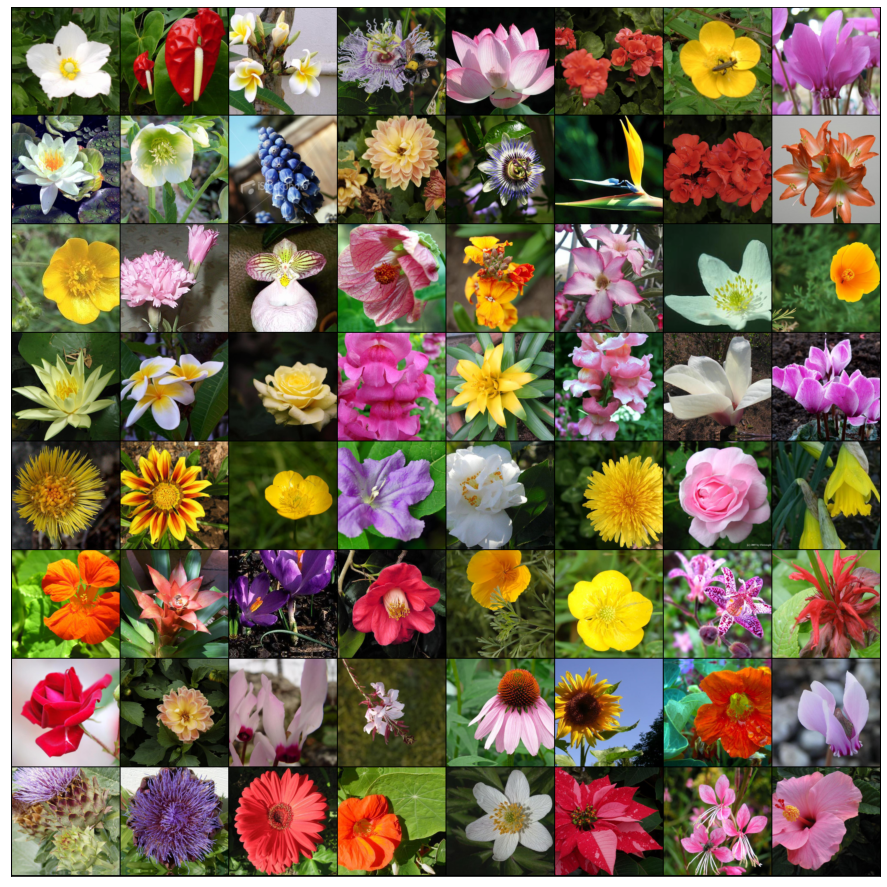

In [ ]:
from torchvision.utils import make_grid

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

Label:  pink primrose (0)


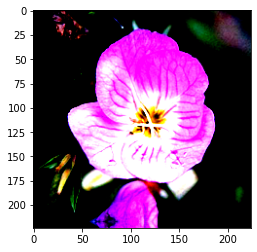

In [ ]:
def show_example(img, label,dataset):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*train_dataset[0],train_dataset)

Label:  hard-leaved pocket orchid (1)


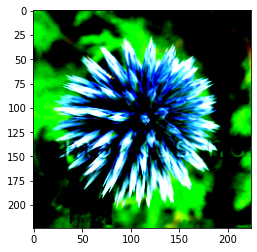

In [ ]:
show_example(*validation_dataset[10],validation_dataset)

Label:  canterbury bells (2)


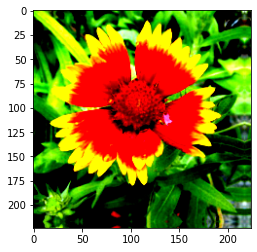

In [ ]:
show_example(*test_dataset[10],test_dataset)

# Step 4: Building and training the classifier

In [ ]:
from collections import OrderedDict

#Set device GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#Load pretrained densenet model
model = models.densenet121(pretrained=True)

#Set up classifer 
for param in model.parameters():
    param.requires_grad = False
     
model.classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(1024,500)),
                            ('relu', nn.ReLU()),
                            ('drop', nn.Dropout(0.2)),
                            ('fc2', nn.Linear(500,102)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))

criterion = nn.NLLLoss()
#Train the classifer
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)
model.to(device);

model

cuda


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 20

#loops through epochs
for epoch in range(epochs):
    for inputs, labels in iter(train_dl):
        steps += 1
        #Move input and labels to devices
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            print("Epoch {}/{}..".format(epoch+1,epochs),
                  "Train loss: {:.4f}".format(running_loss/print_every),
                  "Test loss: {:.4f}".format(test_loss/len(test_dl)),
                  "Test accuracy: {:.4f}".format(accuracy/len(test_dl)))
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 4.1313 Test loss: 3.3885 Test accuracy: 0.2646
Epoch 1/10.. Train loss: 2.7151 Test loss: 2.0274 Test accuracy: 0.5493
Epoch 1/10.. Train loss: 1.8320 Test loss: 1.3006 Test accuracy: 0.6929
Epoch 1/10.. Train loss: 1.2761 Test loss: 1.0110 Test accuracy: 0.7258
Epoch 1/10.. Train loss: 1.0059 Test loss: 0.8205 Test accuracy: 0.8034
Epoch 2/10.. Train loss: 0.8204 Test loss: 0.7994 Test accuracy: 0.7889
Epoch 2/10.. Train loss: 0.6860 Test loss: 0.6516 Test accuracy: 0.8107
Epoch 2/10.. Train loss: 0.5869 Test loss: 0.6344 Test accuracy: 0.8202
Epoch 2/10.. Train loss: 0.5357 Test loss: 0.5611 Test accuracy: 0.8419
Epoch 2/10.. Train loss: 0.5238 Test loss: 0.4835 Test accuracy: 0.8827
Epoch 3/10.. Train loss: 0.4701 Test loss: 0.4798 Test accuracy: 0.8615
Epoch 3/10.. Train loss: 0.3814 Test loss: 0.4692 Test accuracy: 0.8688
Epoch 3/10.. Train loss: 0.4144 Test loss: 0.5275 Test accuracy: 0.8575
Epoch 3/10.. Train loss: 0.4180 Test loss: 0.4717 Test accuracy:

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
print(device)
# TODO: Do validation on the test set
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
   
    if torch.cuda.is_available():
        model.cuda()
        
    #Loops through image and forward
    for images, labels in iter(testloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        
        #calclation
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

cuda


In [ ]:
test_loss, accuracy = validation(model, valid_dl, criterion)
print(accuracy/len(valid_dl))

tensor(0.7220)


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint 
#Define and save checkpoint:

checkpoint = {'input_size': 1024,
                  'output_size': 102,
                  'epochs': epochs,
                  'learning_rate': 0.03,
                  'batch_size': 64,
                  'data_transforms': tranforms,
                  'model': models.densenet121(pretrained=True),
                  'classifier': model.classifier,
                  'optimizer': optimizer,
                  'state_dict': model.state_dict(),
                  'class_to_idx': train_dataset.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
#Load checkpoint
checkpoint = torch.load('checkpoint.pth')

#Set model and parameters
model = checkpoint['model']
model.classifier = checkpoint['classifier']
model.load_state_dict(checkpoint['state_dict'])
model.class_to_idx = checkpoint['class_to_idx']
optimizer = checkpoint['optimizer']
epochs = checkpoint['epochs']
    
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#turn off gradient
for param in model.parameters():
    param.requires_grad = False

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    #Resize but keep ratio
    desired = 256
    image_ratio = image.size[1] / image.size[0]
    new_height = int(desired*image_ratio)
    image = image.resize((desired,new_height))
    
    #Crop center to 224:
    new_size = 224
    left = (image.size[0] - new_size)/2
    top = (image.size[1] - new_size)/2
    right = (image.size[0] + new_size)/2
    bottom = (image.size[1] + new_size)/2
   
    image = image.crop((left, top, right, bottom))
    
    #Get array
    image = np.array(image)
    image = image/255
    
    #Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std_dev = np.array([0.229, 0.224, 0.225])
    
    image = (image - mean) / std_dev
   
    #Tranpose
    image = image.transpose((2,0,1))
    
    return torch.from_numpy(image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

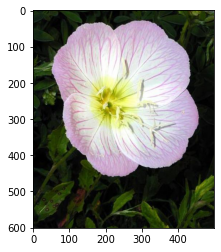

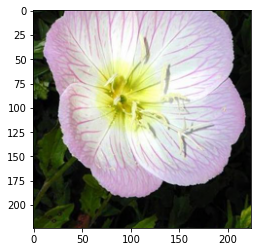

In [ ]:
#Get test image
image_test = Image.open('data/test/1/image_06743.jpg')
#Shdow 2 images
plt.imshow(image_test)

imshow(process_image(image_test))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
#Loops through cat and id to create idx_to_class
idx_to_class = dict([[c,i] for i, c in train_dataset.class_to_idx.items()])
model.idx_to_class = idx_to_class

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.to(device)
    
    #predict
    image = None
    model.eval()
    with Image.open(image_path) as img:
        image = process_image(img)
        
    image = image.to(device)
    image = Variable(image.unsqueeze(0), volatile = True)    
        
    output = model.forward(image.float())
    ps = torch.exp(output)
    prob, idx = ps.topk(topk)
    
    return [y.item() for y in prob.data[0]], [model.idx_to_class[x.item()] for x in idx.data[0]]

In [ ]:
#pirint top5
image_path = 'data/test/102/image_08030.jpg'

prob, classes = predict(image_path, model)

print(prob)
print(classes)
print([cat_to_name[x] for x in classes])


[0.817786693572998, 0.061167407780885696, 0.03694198280572891, 0.03038480505347252, 0.020974216982722282]
['102', '84', '61', '15', '57']
['blackberry lily', 'columbine', 'cautleya spicata', 'yellow iris', 'gaura']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


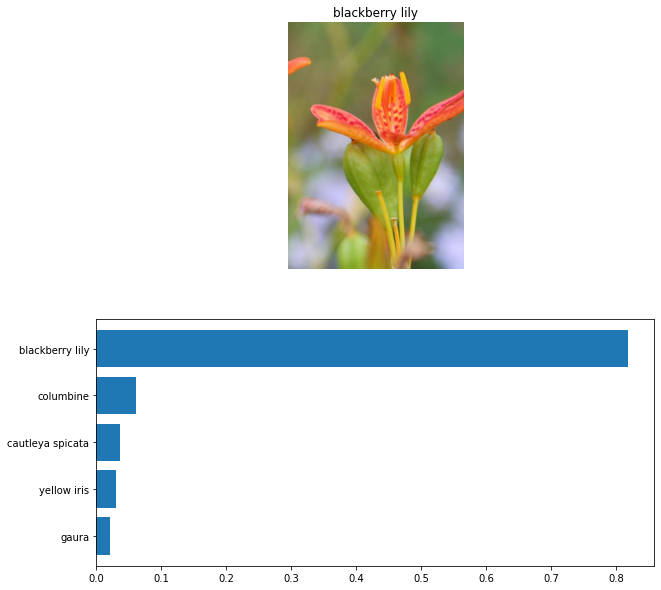

In [ ]:
# TODO: Display an image along with the top 5 classes
def view_prediction(image_path, model):
    prob, classes = predict(image_path, model)
    classes = [cat_to_name[x] for x in classes]
    label = cat_to_name[image_path.split('/')[2]]
    #Show picture
    fig, (ax1, ax2) = plt.subplots(figsize = (10,10), nrows = 2)
    with Image.open(image_path) as img:
        ax1.imshow(img)
    #Set picture label
    ax1.axis('off')
    ax1.set_title(label)
    
    #Get top5 chart
    y_axis = np.arange(len(classes))

    ax2.barh(y_axis, prob, label = True)
    ax2.set_yticks(y_axis)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()

view_prediction(image_path, model)